# Weather Trend Forecasting - Advanced Assessment

This notebook covers advanced assessment tasks:
1. **Advanced EDA** - Anomaly detection to identify and analyze outliers
2. **Forecasting with Multiple Models** - Build, compare, and ensemble models
3. **Unique Analyses** - Climate, environmental impact, feature importance, spatial & geographical patterns

---

## 1. Advanced EDA - Anomaly Detection

**Goal:** Identify unusual weather records that may represent sensor errors, extreme events, or data quality issues. We use **Isolation Forest** (tree-based, efficient for high dimensions) and **Local Outlier Factor (LOF)** (density-based, captures local anomalies) to flag outliers across key numeric features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option('display.max_columns', 50)
%matplotlib inline

### 1.1 Load Data

We load the **standardized** dataset (`data_standardized.csv`) from the basic assessment. Standardization ensures features are on comparable scales for anomaly detection algorithms. The cleaned data has no missing values and outliers already winsorized.

In [5]:
# Load standardized data from basic assessment
df = pd.read_csv('datasets/basic_assessment/data_standardized.csv')

df['last_updated'] = pd.to_datetime(df['last_updated'], errors='coerce')
df = df.dropna(subset=['last_updated'])

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (125501, 41)


,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,wind_mph,wind_kph,wind_degree,wind_direction,pressure_mb,pressure_in,precip_mm,precip_in,humidity,cloud,feels_like_celsius,feels_like_fahrenheit,visibility_km,visibility_miles,uv_index,gust_mph,gust_kph,air_quality_Carbon_Monoxide,air_quality_Ozone,air_quality_Nitrogen_dioxide,air_quality_Sulphur_dioxide,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15:00,0.530583,79.8,Partly Cloudy,8.3,0.054396,338,NNW,-0.309580,29.89,-0.607706,0.00,-1.755358,-0.294376,0.246755,77.5,0.226074,6.0,1.001538,9.5,-0.264344,-0.254229,1.419014,-0.583334,-0.283655,-0.428079,-0.148852,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,0.161009
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45:00,-0.290942,66.2,Partly cloudy,6.9,-0.207562,320,NW,-0.309580,29.88,1.907349,0.00,1.158541,1.025911,-0.301514,66.2,0.226074,6.0,0.440056,11.4,0.031481,-0.361037,1.235754,-0.591586,-0.286367,-0.621297,-0.311086,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,0.161009
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45:00,0.141439,73.4,Sunny,9.4,0.278930,280,W,-0.461317,29.85,-0.607706,0.00,-1.547222,-1.174567,0.185836,76.4,0.226074,6.0,0.440056,13.9,0.403648,0.083483,-1.500286,2.057113,0.074307,-0.375142,-0.202930,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,0.161009
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45:00,-1.663755,43.3,Light drizzle,7.4,-0.120242,215,SW,-1.068265,29.75,1.907349,0.01,-0.215154,1.759404,-1.624321,38.9,-2.767566,1.0,-0.402165,8.5,-0.417028,-0.391004,0.177990,-0.562706,-0.283655,-0.631885,-0.318341,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,0.161009
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45:00,0.465726,78.8,Partly cloudy,8.1,0.016973,150,SSE,-0.461317,29.85,-0.607706,0.00,0.950405,0.292418,0.542646,83.6,0.226074,6.0,1.282278,12.5,0.203250,3.186928,-1.281660,2.370667,0.565148,4.203868,1.405569,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,0.161009


### 1.2 Anomaly Detection with Isolation Forest

**Isolation Forest** randomly partitions data with binary trees; anomalies are isolated in fewer splits (shorter path lengths). We fit on key weather features (temperature, humidity, pressure, precip, wind, cloud, visibility). Contamination rate controls the expected proportion of anomalies.

In [6]:
from sklearn.ensemble import IsolationForest

anomaly_cols = ['temperature_celsius', 'humidity', 'pressure_mb', 'precip_mm', 
                'wind_kph', 'cloud', 'visibility_km', 'uv_index', 'feels_like_celsius']
anomaly_cols = [c for c in anomaly_cols if c in df.columns]

df_anomaly = df[anomaly_cols]
X_scaled = df_anomaly.values

# Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df_anomaly = df_anomaly.copy()
df_anomaly['anomaly_score'] = iso_forest.fit_predict(X_scaled)
df_anomaly['anomaly'] = df_anomaly['anomaly_score'] == -1

n_anomalies = df_anomaly['anomaly'].sum()
print(f"Anomalies detected: {n_anomalies} ({n_anomalies/len(df_anomaly)*100:.2f}%)")

Anomalies detected: 6275 (5.00%)


### 1.3 Local Outlier Factor (LOF)

**LOF** compares each point's local density to its neighbors'. Points in low-density regions (relative to neighbors) get high LOF scores and are flagged as anomalies. LOF captures context-dependent outliers that Isolation Forest might miss.

In [7]:
from sklearn.neighbors import LocalOutlierFactor

# LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_pred = lof.fit_predict(X_scaled)
df_anomaly['lof_anomaly'] = lof_pred == -1
df_anomaly['lof_score'] = -lof.negative_outlier_factor_

n_lof = df_anomaly['lof_anomaly'].sum()
print(f"LOF anomalies detected: {n_lof} ({n_lof/len(df_anomaly)*100:.2f}%)")

# Agreement between methods
agreement = (df_anomaly['anomaly'] == df_anomaly['lof_anomaly']).sum()
print(f"Both methods agree on anomaly status: {agreement} ({agreement/len(df_anomaly)*100:.1f}%)")

LOF anomalies detected: 6275 (5.00%)
Both methods agree on anomaly status: 114599 (91.3%)


### 1.4 Analyze and Visualize Anomalies

**Insights:** We compare anomaly vs normal records across temperature, humidity, pressure, precipitation, and other features. Box plots and distributions reveal which variables drive anomaly flags—e.g., extreme temperatures or unusual pressure-humidity combinations. Anomalies may indicate heat waves, cold snaps, or data errors.

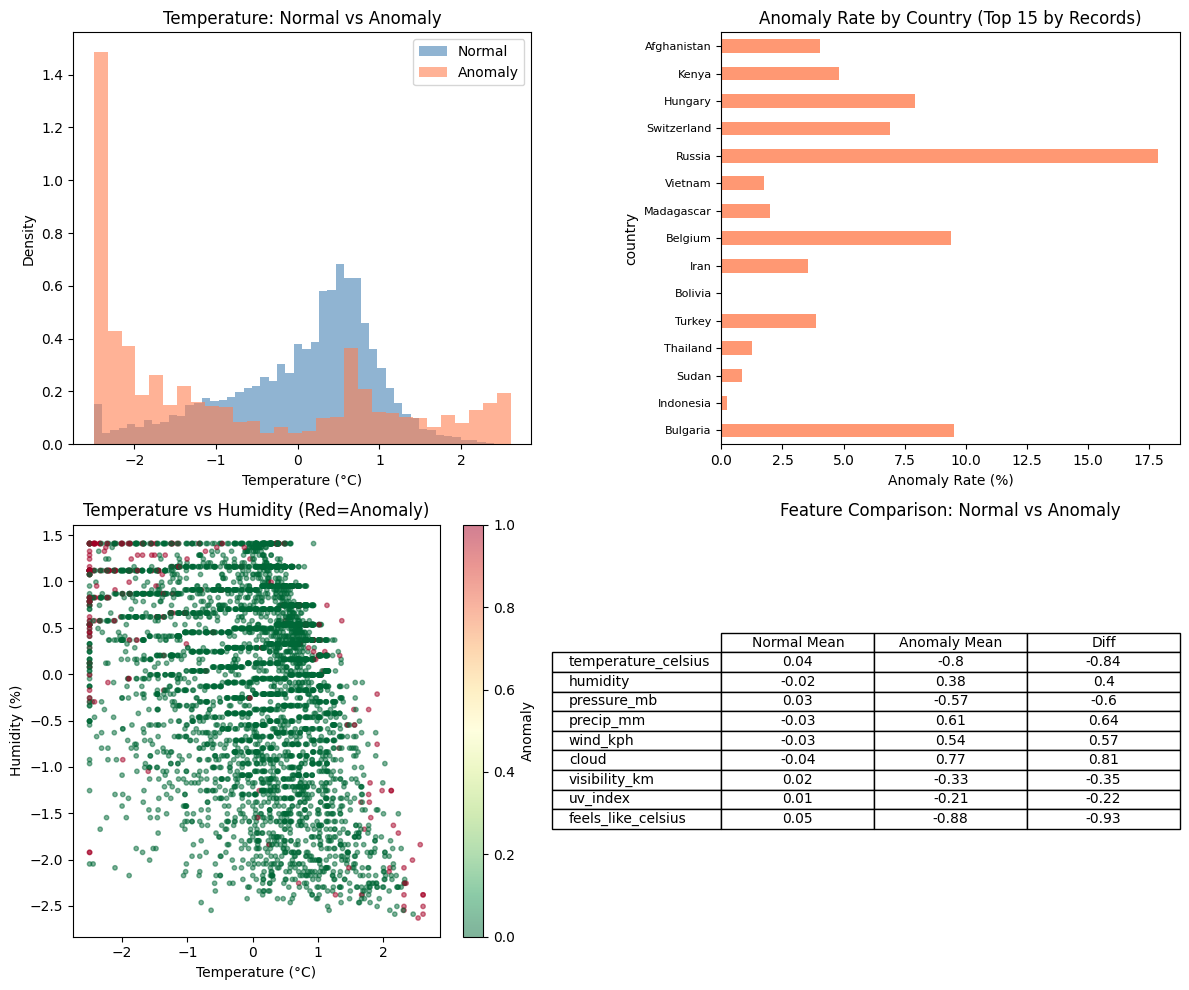

In [8]:
# Add anomaly flag as a column
df_full = df.copy()
df_full = df_full.loc[df_anomaly.index]
df_full['anomaly'] = df_anomaly['anomaly'].values

# Anomaly vs normal
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Temperature distribution: normal vs anomaly
ax1 = axes[0, 0]
normal_temp = df_full[~df_full['anomaly']]['temperature_celsius']
anomaly_temp = df_full[df_full['anomaly']]['temperature_celsius']
ax1.hist(normal_temp, bins=50, alpha=0.6, label='Normal', color='steelblue', density=True)
ax1.hist(anomaly_temp, bins=30, alpha=0.6, label='Anomaly', color='coral', density=True)
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Density')
ax1.set_title('Temperature: Normal vs Anomaly')
ax1.legend()

# Anomaly rate by country (top 15 by record count)
ax2 = axes[0, 1]
country_anomaly = df_full.groupby('country').agg({'anomaly': 'mean', 'country': 'count'}).rename(columns={'country': 'count'})
country_anomaly = country_anomaly[country_anomaly['count'] >= 100].nlargest(15, 'count')
country_anomaly['anomaly_pct'] = country_anomaly['anomaly'] * 100
country_anomaly['anomaly_pct'].plot(kind='barh', ax=ax2, color='coral', alpha=0.8)
ax2.set_xlabel('Anomaly Rate (%)')
ax2.set_title('Anomaly Rate by Country (Top 15 by Records)')
ax2.tick_params(axis='y', labelsize=8)

# Scatter: Temperature vs Humidity, colored by anomaly
ax3 = axes[1, 0]
sample = df_full.sample(min(5000, len(df_full)), random_state=42)
scatter = ax3.scatter(sample['temperature_celsius'], sample['humidity'], 
                     c=sample['anomaly'], cmap='RdYlGn_r', alpha=0.5, s=10)
ax3.set_xlabel('Temperature (°C)')
ax3.set_ylabel('Humidity (%)')
ax3.set_title('Temperature vs Humidity (Red=Anomaly)')
plt.colorbar(scatter, ax=ax3, label='Anomaly')

# Key stats: anomaly vs normal
ax4 = axes[1, 1]
ax4.axis('off')
stats_normal = df_full[~df_full['anomaly']][anomaly_cols].describe().loc[['mean', 'std']]
stats_anomaly = df_full[df_full['anomaly']][anomaly_cols].describe().loc[['mean', 'std']]
comparison = pd.DataFrame({
    'Normal Mean': stats_normal.loc['mean'],
    'Anomaly Mean': stats_anomaly.loc['mean'],
    'Diff': stats_anomaly.loc['mean'] - stats_normal.loc['mean']
})
ax4.table(cellText=comparison.round(2).values,
          rowLabels=comparison.index,
          colLabels=comparison.columns,
          loc='center',
          cellLoc='center')
ax4.set_title('Feature Comparison: Normal vs Anomaly')

plt.tight_layout()
plt.show()

### 1.5 Anomaly Examples and Insights

**Takeaways:** We examine sample anomaly rows to interpret causes such as extreme locations, unusual weather events, or potential data issues. This informs whether to exclude anomalies from modeling or treat them as valid extremes.

In [ ]:
# Sample of anomaly
anomaly_sample = df_full[df_full['anomaly']].nsmallest(10, 'temperature_celsius')[['country', 'location_name', 'last_updated', 'temperature_celsius', 'humidity', 'precip_mm', 'pressure_mb']]
print("Example anomalies (cold extremes):")
display(anomaly_sample)

# Anomalies with extreme precipitation
anomaly_precip = df_full[df_full['anomaly']].nlargest(5, 'precip_mm')[['country', 'location_name', 'last_updated', 'temperature_celsius', 'precip_mm', 'humidity']]
print("\nExample anomalies (high precipitation):")
display(anomaly_precip)

print("\nKey insights:")
print(f"- Anomalies often represent extreme weather: very cold/hot temps, heavy precipitation, unusual pressure")
print(f"- {df_full['anomaly'].sum()} records ({df_full['anomaly'].mean()*100:.2f}%) flagged as anomalous")

Example anomalies (cold extremes):


,country,location_name,last_updated,temperature_celsius,humidity,precip_mm,pressure_mb
6816,Australia,Canberra,2024-06-19 23:45:00,-2.49609,1.408303,-0.607706,0.449105
10320,Chile,Santiago,2024-07-07 09:00:00,-2.49609,1.116913,-0.607706,1.207790
29013,Kazakhstan,Astana,2024-10-13 14:30:00,-2.49609,0.575761,-0.607706,2.118212
30015,Mongolia,Ulaanbaatar,2024-10-18 17:30:00,-2.49609,-1.505595,-0.607706,2.421686
30405,Mongolia,Ulaanbaatar,2024-10-20 17:30:00,-2.49609,0.867151,1.907349,0.600842
33831,Kazakhstan,Astana,2024-11-07 14:00:00,-2.49609,0.076235,-0.272365,-0.613054
34221,Kazakhstan,Astana,2024-11-09 14:00:00,-2.49609,0.325998,-0.272365,0.904316
34611,Kazakhstan,Astana,2024-11-11 14:00:00,-2.49609,0.825524,1.907349,-0.309580
34946,Canada,Ottawa,2024-11-13 04:00:00,-2.49609,0.325998,-0.607706,2.421686
35001,Kazakhstan,Astana,2024-11-13 14:00:00,-2.49609,1.116913,1.907349,-0.006106



Example anomalies (high precipitation):


,country,location_name,last_updated,temperature_celsius,precip_mm,humidity
3,Andorra,Andorra La Vella,2024-05-16 10:45:00,-1.663755,1.907349,-0.215154
176,Tonga,Nuku`Aloia,2024-05-16 21:45:00,0.141439,1.907349,1.408303
220,Bulgaria,Sofia,2024-05-16 17:00:00,-1.155706,1.907349,0.659015
302,Marshall Islands,Majuro,2024-05-17 02:00:00,0.681917,1.907349,0.742269
345,Belgium,'S Gravenstaffel,2024-05-16 16:15:00,-0.831420,1.907349,1.158541



Key insights:
- Anomalies often represent extreme weather: very cold/hot temps, heavy precipitation, unusual pressure
- 6275 records (5.00%) flagged as anomalous


## 2. Forecasting with Multiple Models

We build **multiple regression models** (Linear Regression, Ridge, Random Forest, Gradient Boosting, XGBoost) to forecast daily mean temperature. Models are compared on MAE, RMSE, MAPE, and R². An **ensemble** (simple and weighted average) combines predictions to potentially improve accuracy beyond any single model.

### 2.1 Prepare Time Series Data

We use **cleaned (raw-scale) data** for interpretable metrics. Daily series is built by aggregating mean temperature, total precipitation, etc. per day. Lag features (1–3 days) and cyclical time features (day of year, month) are created for next-day temperature prediction.

In [ ]:
df_forecast = pd.read_csv('datasets/basic_assessment/data_cleaned.csv')
df_forecast['last_updated'] = pd.to_datetime(df_forecast['last_updated'])
df_forecast['date'] = df_forecast['last_updated'].dt.date

# Daily time series
daily_ts = df_forecast.groupby('date').agg({
    'temperature_celsius': 'mean',
    'precip_mm': 'sum',
    'humidity': 'mean'
}).reset_index()
daily_ts['date'] = pd.to_datetime(daily_ts['date'])
daily_ts = daily_ts.sort_values('date').reset_index(drop=True)

# Lag and time features
daily_ts['temp_lag1'] = daily_ts['temperature_celsius'].shift(1)
daily_ts['temp_lag7'] = daily_ts['temperature_celsius'].shift(7)
daily_ts['day_of_year'] = daily_ts['date'].dt.dayofyear
daily_ts['month'] = daily_ts['date'].dt.month
daily_ts = daily_ts.dropna()

feature_cols = ['temp_lag1', 'temp_lag7', 'day_of_year', 'month', 'humidity']
X = daily_ts[feature_cols]
y = daily_ts['temperature_celsius']

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Time series shape: {daily_ts.shape}")
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Time series shape: (639, 8)
Train: 511, Test: 128


### 2.2 Build and Compare Multiple Models

**Models:** Linear Regression (baseline), Ridge (L2 regularization), Random Forest (non-linear, robust), Gradient Boosting and XGBoost (strong ensemble learners). Time-based train-test split preserves temporal order. Each model is evaluated on MAE, RMSE, MAPE, and R² to identify the best performer.

In [11]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100

def evaluate(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mape(y_true, y_pred),
        'R²': r2_score(y_true, y_pred)
    }

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
}

predictions = {}
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    metrics = evaluate(y_test, y_pred)
    metrics['Model'] = name
    results.append(metrics)

results_df = pd.DataFrame(results).set_index('Model')
results_df

,MAE,RMSE,MAPE,R²
Model,,,,
Linear Regression,0.469513,1.216975,4.301008,0.665267
Ridge,0.469536,1.216029,4.300502,0.665787
Random Forest,0.841839,1.507510,7.223244,0.486364
Gradient Boosting,0.808695,1.477740,7.006875,0.506450
XGBoost,0.892644,1.532741,7.519352,0.469026


### 2.3 Create Ensemble Model

**Ensemble strategies:** (1) **Simple average**—equal weight for all models; (2) **Weighted average**—weights by inverse RMSE so better models contribute more. Ensembles often reduce variance and improve robustness when individual models have complementary errors.

In [12]:
# Simple average ensemble
pred_array = np.column_stack([predictions[name] for name in models.keys()])
ensemble_simple = pred_array.mean(axis=1)

# Weighted average
inv_rmse = 1 / results_df['RMSE'].values
weights = inv_rmse / inv_rmse.sum()
ensemble_weighted = np.average(pred_array, axis=1, weights=weights)

# Evaluate ensemble
ensemble_results = pd.DataFrame([
    {**evaluate(y_test, ensemble_simple), 'Model': 'Ensemble (Simple Avg)'},
    {**evaluate(y_test, ensemble_weighted), 'Model': 'Ensemble (Weighted Avg)'}
]).set_index('Model')

all_results = pd.concat([results_df, ensemble_results])
all_results

,MAE,RMSE,MAPE,R²
Model,,,,
Linear Regression,0.469513,1.216975,4.301008,0.665267
Ridge,0.469536,1.216029,4.300502,0.665787
Random Forest,0.841839,1.507510,7.223244,0.486364
Gradient Boosting,0.808695,1.477740,7.006875,0.506450
XGBoost,0.892644,1.532741,7.519352,0.469026
Ensemble (Simple Avg),0.503018,1.174387,4.886533,0.688285
Ensemble (Weighted Avg),0.470797,1.149032,4.655297,0.701600


### 2.4 Model Comparison Visualization

**Insights:** Bar charts compare MAE, RMSE, MAPE, R² across all models and ensembles. Actual vs predicted plots show fit quality. The best model (or ensemble) is selected based on these metrics.

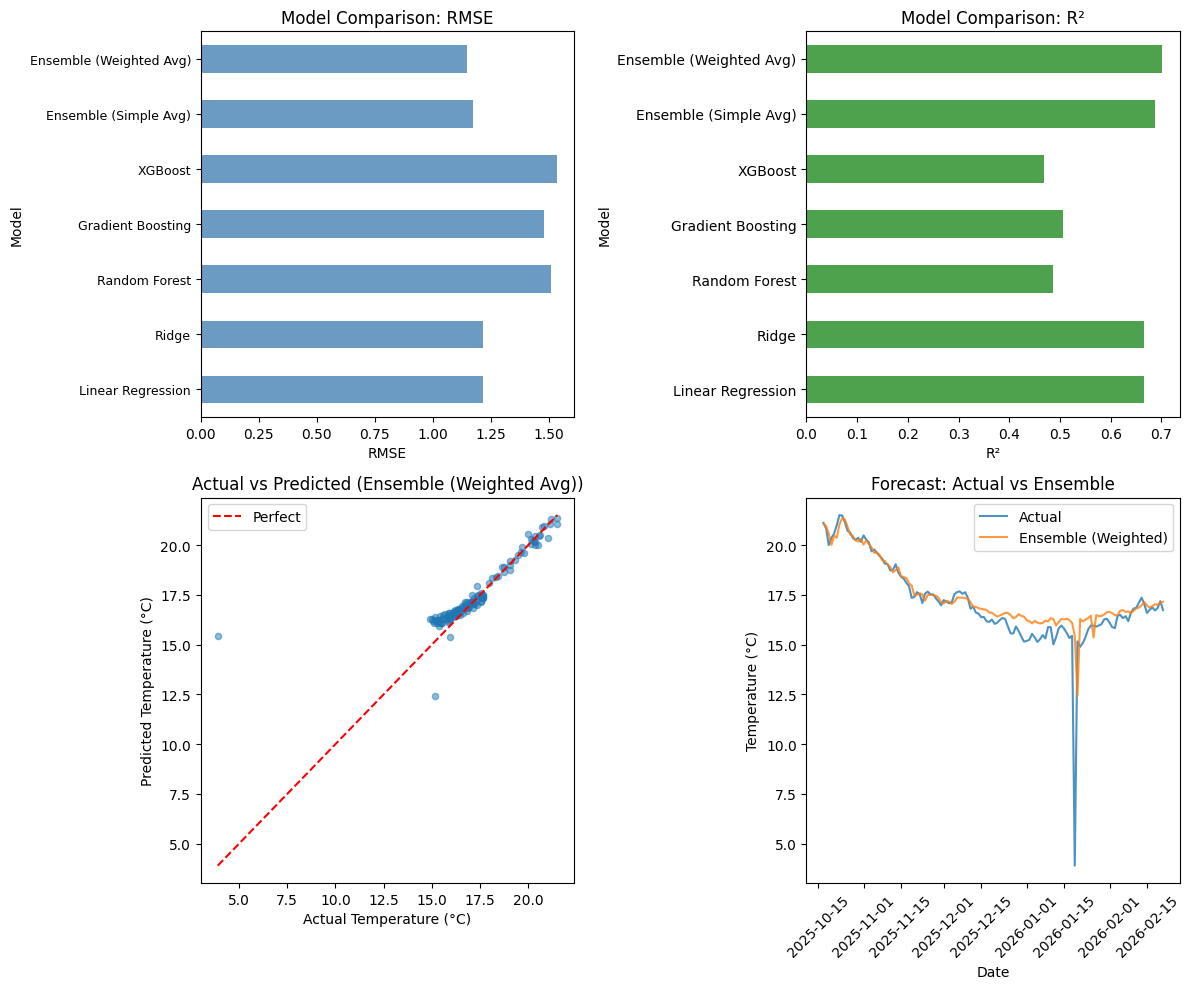

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# RMSE comparison
ax1 = axes[0, 0]
all_results['RMSE'].plot(kind='barh', ax=ax1, color='steelblue', alpha=0.8)
ax1.set_xlabel('RMSE')
ax1.set_title('Model Comparison: RMSE')
ax1.tick_params(axis='y', labelsize=9)

# R² comparison
ax2 = axes[0, 1]
all_results['R²'].plot(kind='barh', ax=ax2, color='forestgreen', alpha=0.8)
ax2.set_xlabel('R²')
ax2.set_title('Model Comparison: R²')

# Actual vs Predicted (best model by RMSE)
ax3 = axes[1, 0]
best_idx = all_results['RMSE'].idxmin()
if best_idx == 'Ensemble (Weighted Avg)':
    best_pred = ensemble_weighted
elif best_idx == 'Ensemble (Simple Avg)':
    best_pred = ensemble_simple
else:
    best_pred = predictions[best_idx]
ax3.scatter(y_test, best_pred, alpha=0.5, s=20)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect')
ax3.set_xlabel('Actual Temperature (°C)')
ax3.set_ylabel('Predicted Temperature (°C)')
ax3.set_title(f'Actual vs Predicted ({best_idx})')
ax3.legend()

# Time series plot: actual vs ensemble predicted
ax4 = axes[1, 1]
test_dates = daily_ts['date'].iloc[split_idx:split_idx + len(y_test)]
ax4.plot(test_dates, y_test.values, label='Actual', alpha=0.8)
ax4.plot(test_dates, ensemble_weighted, label='Ensemble (Weighted)', alpha=0.8)
ax4.set_xlabel('Date')
ax4.set_ylabel('Temperature (°C)')
ax4.set_title('Forecast: Actual vs Ensemble')
ax4.legend()
ax4.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## 3. Unique Analyses

We conduct four domain-specific analyses: **climate** (long-term trends, temperature by latitude), **environmental impact** (air quality vs weather), **feature importance** (which predictors drive temperature), and **spatial/geographical patterns** (temperature and precipitation by location).

### 3.1 Climate Analysis

**Long-term trends:** We analyze temperature over time to detect warming or cooling patterns. **Temperature by latitude** segments data into climate zones (tropical, temperate, polar) to compare mean temperatures. This reveals expected gradients—warmer near equator, cooler toward poles—and seasonal variations by zone.

C:\Users\Charlie Shang\AppData\Local\Temp\ipykernel_33372\1757091564.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_climate = df_ua.groupby(['year', 'month', 'climate_zone'])['temperature_celsius'].mean().reset_index()
C:\Users\Charlie Shang\AppData\Local\Temp\ipykernel_33372\1757091564.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zone_temp = df_ua.groupby('climate_zone')['temperature_celsius'].agg(['mean', 'std'])


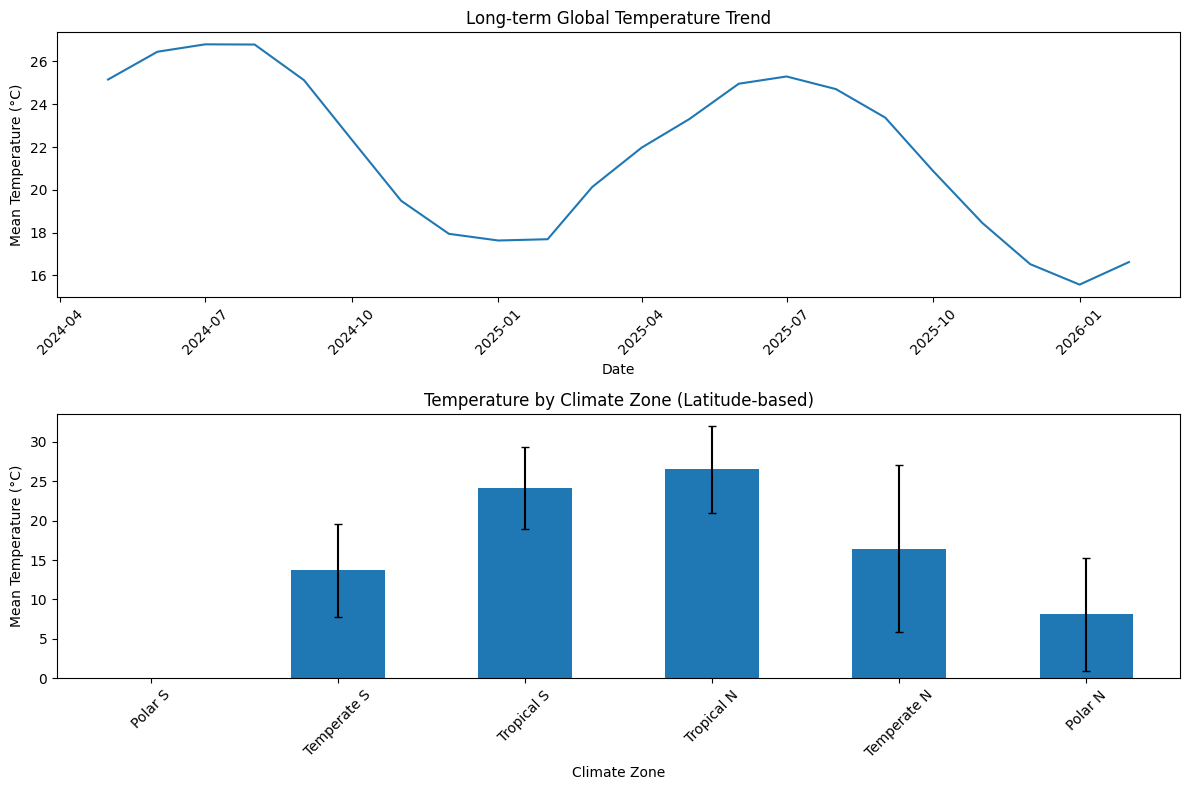

In [14]:
df_ua = pd.read_csv('datasets/basic_assessment/data_cleaned.csv')
df_ua['last_updated'] = pd.to_datetime(df_ua['last_updated'])
df_ua['date'] = df_ua['last_updated'].dt.date
df_ua['month'] = df_ua['last_updated'].dt.month
df_ua['year'] = df_ua['last_updated'].dt.year

# Climate zones by latitude
df_ua['climate_zone'] = pd.cut(df_ua['latitude'], bins=[-90, -60, -30, 0, 30, 60, 90],
                               labels=['Polar S', 'Temperate S', 'Tropical S', 'Tropical N', 'Temperate N', 'Polar N'])

# Monthly mean temperature by climate zone
monthly_climate = df_ua.groupby(['year', 'month', 'climate_zone'])['temperature_celsius'].mean().reset_index()
monthly_climate['period'] = monthly_climate['year'].astype(str) + '-' + monthly_climate['month'].astype(str).str.zfill(2)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
# Long-term trend: global monthly mean
global_monthly = df_ua.groupby(['year', 'month'])['temperature_celsius'].mean().reset_index()
global_monthly['period'] = pd.to_datetime(global_monthly['year'].astype(str) + '-' + global_monthly['month'].astype(str).str.zfill(2))
axes[0].plot(global_monthly['period'], global_monthly['temperature_celsius'])
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Mean Temperature (°C)')
axes[0].set_title('Long-term Global Temperature Trend')
axes[0].tick_params(axis='x', rotation=45)

# Temperature by climate zone (mean)
zone_temp = df_ua.groupby('climate_zone')['temperature_celsius'].agg(['mean', 'std'])
zone_temp.plot(kind='bar', y='mean', yerr='std', ax=axes[1], capsize=3, legend=False)
axes[1].set_xlabel('Climate Zone')
axes[1].set_ylabel('Mean Temperature (°C)')
axes[1].set_title('Temperature by Climate Zone (Latitude-based)')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

### 3.2 Environmental Impact - Air Quality

**Correlation heatmap:** We examine relationships between air quality metrics (CO, Ozone, NO₂, SO₂, PM2.5, PM10) and weather variables (temperature, humidity, wind, pressure). This informs how weather conditions influence pollutant dispersion and helps identify drivers of poor air quality.

Air quality vs Temperature correlation:
air_quality_Ozone               0.279346
air_quality_PM10                0.110217
air_quality_PM2.5               0.050662
air_quality_Carbon_Monoxide    -0.009262
air_quality_Sulphur_dioxide    -0.037209
air_quality_Nitrogen_dioxide   -0.152836
dtype: float64


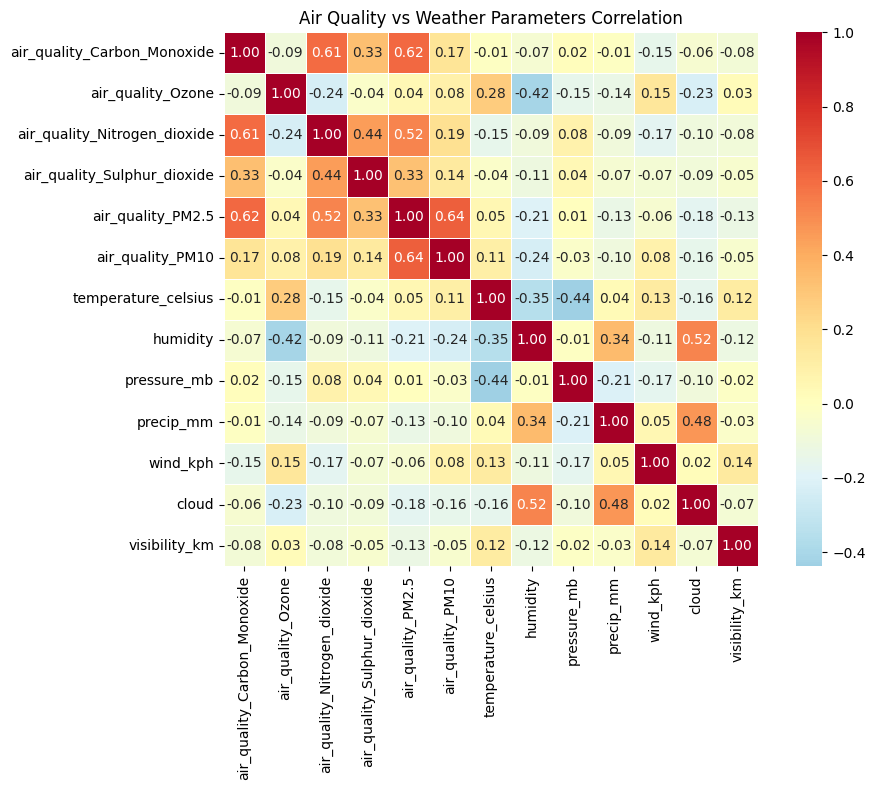

In [15]:
# Air quality columns
aq_cols = [c for c in df_ua.columns if 'air_quality' in c and c != 'air_quality_us-epa-index' and c != 'air_quality_gb-defra-index']
weather_cols = ['temperature_celsius', 'humidity', 'pressure_mb', 'precip_mm', 'wind_kph', 'cloud', 'visibility_km']

# Correlation: air quality vs weather
aq_weather = df_ua[aq_cols + weather_cols].dropna()
corr_aq = aq_weather[aq_cols].corrwith(aq_weather['temperature_celsius']).sort_values(ascending=False)
print("Air quality vs Temperature correlation:")
print(corr_aq)

# Heatmap: key air pollutants vs weather
corr_matrix = aq_weather[aq_cols[:6] + weather_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r', center=0, square=True, linewidths=0.5)
plt.title('Air Quality vs Weather Parameters Correlation')
plt.tight_layout()
plt.show()

### 3.3 Feature Importance

**Techniques:** Random Forest built-in importance and permutation importance. We identify which features (humidity, pressure, lagged temp, etc.) best predict temperature. `feels_like_celsius` is excluded as a near-duplicate of temperature to avoid circular predictors. Results guide feature selection for future models.

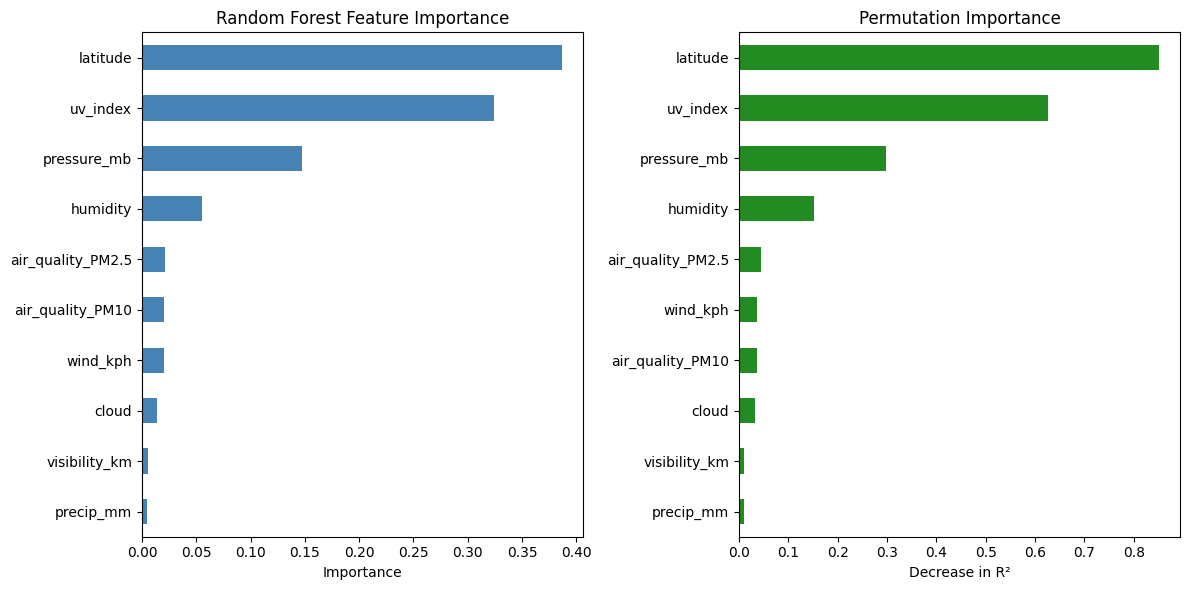

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

feat_cols = ['humidity', 'pressure_mb', 'precip_mm', 'wind_kph', 'cloud', 'visibility_km', 
             'uv_index', 'latitude', 'air_quality_PM2.5', 'air_quality_PM10']
feat_cols = [c for c in feat_cols if c in df_ua.columns]
df_feat = df_ua[feat_cols + ['temperature_celsius']].dropna()
X_fi = df_feat[feat_cols]
y_fi = df_feat['temperature_celsius']

# Random Forest feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_fi, y_fi)
imp_rf = pd.Series(rf.feature_importances_, index=feat_cols).sort_values(ascending=True)

# Permutation importance
perm = permutation_importance(rf, X_fi, y_fi, n_repeats=5, random_state=42)
imp_perm = pd.Series(perm.importances_mean, index=feat_cols).sort_values(ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
imp_rf.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Random Forest Feature Importance')
axes[0].set_xlabel('Importance')
imp_perm.plot(kind='barh', ax=axes[1], color='forestgreen')
axes[1].set_title('Permutation Importance')
axes[1].set_xlabel('Decrease in R²')
plt.tight_layout()
plt.show()

### 3.4 Spatial Analysis

**Grid aggregation:** We bin observations into 5°×5° latitude-longitude grids and compute mean temperature and precipitation per grid. Heatmaps reveal spatial patterns—e.g., warmer coastal vs inland areas, precipitation belts—supporting geographic interpretation of weather variability.

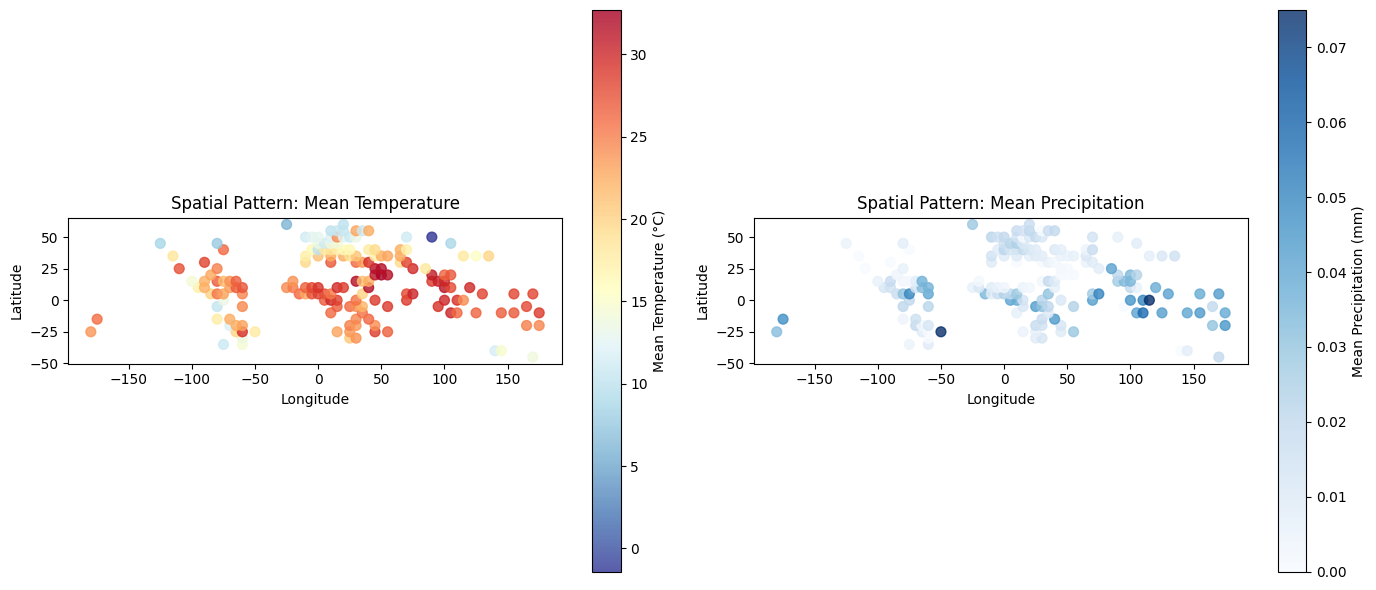

In [17]:
# Spatial aggregation: mean temperature by lat/lon grid
df_ua['lat_bin'] = (df_ua['latitude'] // 5) * 5
df_ua['lon_bin'] = (df_ua['longitude'] // 5) * 5
spatial_temp = df_ua.groupby(['lat_bin', 'lon_bin']).agg({
    'temperature_celsius': 'mean',
    'precip_mm': 'mean',
    'humidity': 'mean'
}).reset_index()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
scatter = plt.scatter(spatial_temp['lon_bin'], spatial_temp['lat_bin'], 
                     c=spatial_temp['temperature_celsius'], cmap='RdYlBu_r', s=50, alpha=0.8)
plt.colorbar(scatter, label='Mean Temperature (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Pattern: Mean Temperature')
plt.gca().set_aspect('equal')

plt.subplot(1, 2, 2)
scatter2 = plt.scatter(spatial_temp['lon_bin'], spatial_temp['lat_bin'], 
                      c=spatial_temp['precip_mm'], cmap='Blues', s=50, alpha=0.8)
plt.colorbar(scatter2, label='Mean Precipitation (mm)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Pattern: Mean Precipitation')
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

### 3.5 Geographical Patterns

**Country and continent analysis:** Mean temperature and precipitation by country (and continent, inferred from timezone) highlight regional differences. Bar plots or maps show which countries/regions are warmest, wettest, or most variable—useful for regional climate summaries and targeting forecasting efforts.

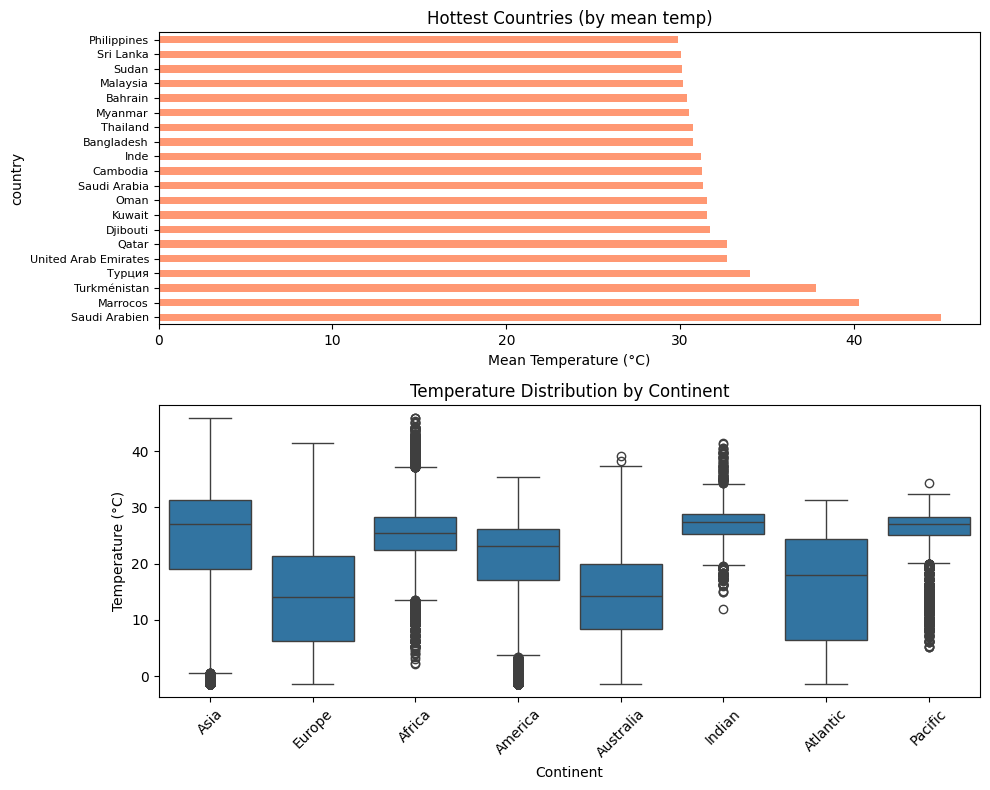

In [18]:
# Continent from timezone
df_ua['continent'] = df_ua['timezone'].str.split('/').str[0]

# Temperature by country (top 20)
country_temp = df_ua.groupby('country')['temperature_celsius'].mean().sort_values(ascending=False).head(20)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
country_temp.plot(kind='barh', ax=axes[0], color='coral', alpha=0.8)
axes[0].set_xlabel('Mean Temperature (°C)')
axes[0].set_title('Hottest Countries (by mean temp)')
axes[0].tick_params(axis='y', labelsize=8)

# Box plot: temperature by continent
main_continents = df_ua['continent'].value_counts().head(8).index
df_ua_cont = df_ua[df_ua['continent'].isin(main_continents)]
sns.boxplot(data=df_ua_cont, x='continent', y='temperature_celsius', ax=axes[1])
axes[1].set_xlabel('Continent')
axes[1].set_ylabel('Temperature (°C)')
axes[1].set_title('Temperature Distribution by Continent')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()